# Load packages

In [11]:

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from scipy.sparse.linalg import eigsh
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Pauli Matrices
sx = np.array([[0, 1], [1, 0]])
sz = np.array([[1, 0], [0, -1]])
s0 = np.array([[1, 0], [0, 1]])
sp = np.array([[0, 1], [0, 0]])
sm = np.array([[0, 0], [1, 0]])

In [12]:
from matplotlib import rc, rcParams
rcParams['ytick.direction'] = 'in'
rcParams['xtick.direction'] = 'in'

# Functions

In [13]:
# model Hamiltonian
# Truncation of charge states
NMAX = 50

# M is the number of phase points included
# Total size of the Hamiltonian is 2*M
def hamiltonian(Ec, gap, tau, Ng, N): # two level model applied
    M = N
    a = 4 * np.pi / M # lattice spacing
    t = 4 * Ec / a**2 # hopping
    
    # charging energy
    ham = 2 * t * np.eye(M) + 0j
    ham += t * np.exp(1j * 0.5 * Ng * a) * np.eye(M, k = 1)
    ham += t * np.exp(-1j * 0.5 * Ng * a) * np.eye(M, k = -1)
    ham += t * np.exp(-1j * 0.5 * Ng * a) * np.eye(M, k = M-1) # boundary condition
    ham += t * np.exp(1j * 0.5 * Ng * a) * np.eye(M, k = -M+1) # boundary condition
    ham = np.kron(ham, s0)
    
    phis = np.linspace(0, 4*np.pi, M, endpoint=False)
    ham += gap * np.kron(np.diag(np.cos(phis / 2)), sz)
    ham += gap * np.sqrt(1 - tau) * np.kron(np.diag(np.sin(phis / 2)), sx)
    return ham

In [14]:
# solve two-level hamil
eps_sample = np.array([0.1,0.3,0.5,1,1.5,2,3,4,5,6,7,8,9,10,12,14,16,18,20,25,30,35,40,45,50,55,60,65,70,80,90,100])
# array of test epsilons
def get_energy(Ec, Delta, T, sparse=False, project = False, ng = 0, N = 51):
    ham = hamiltonian(Ec, Delta, T, Ng=ng, N=N)
    if sparse:
        evals = eigsh(ham, k=2, sigma=0)[0]
    else:
        evals = np.linalg.eigvalsh(ham)
    return np.array([evals[0],evals[1], evals[2], evals[3], evals[4], evals[5]])

def get_energies_1band(Ec, Delta, T, ng, n_deg = 0.5, N = 51):
    E0 = np.zeros(len(ng))
    E1 = np.zeros(len(ng))
    E2 = np.zeros(len(ng))
    for i,n in enumerate(ng):
        en = get_energy(Ec, Delta, T, ng = n, N = N)
        if np.mod(0.5+n,2)<=1:
            E0[i] = en[0]
            E1[i] = en[3]
            E2[i] = en[4]
        else:
            E0[i] = en[1]
            E1[i] = en[2]
            E2[i] = en[5]
        if n == 0:
            E_ = en[0]
        if n == n_deg:
            E01 = en[2] - en[0]
            print(E01, Delta, Ec)
    E0 = np.array((E0-E_)/E01)  
    E1 = np.array((E1-E_)/E01) 
    E2 = np.array((E2-E_)/E01) 
    return [E0, E1, E2]

In [15]:
# model functions
def bound_state_equation(x, phi, gamma1, gamma2, gap, xr): # Eq. 1 in the dispersion paper, PRL 124, 246803 (2020)
    gamma = gamma1 + gamma2
    omega = ((gap**2 - x**2) * (x**2 - xr**2 - gamma**2/4) + gap**2 * gamma1 * gamma2 * np.sin(phi/2)**2)
    return omega + gamma * x**2 * np.sqrt(gap**2 - x**2)

def T_BW(gamma1, gamma2, xr): # extract transmission based on \epsilon_r and Gammas
    T = gamma1*gamma2/(xr**2+1/4*(gamma1+gamma2)**2)
    return T

def Delta_tilde(gamma1, gamma2, gap, xr): # get E(0) = \tilde(\Delta), given Gammas, Al gap and epsilon_r
    sol = brentq(lambda x: bound_state_equation(x, 0, gamma1/gap, gamma2/gap, 1, xr/gap), 0, 1-1e-3, full_output=False)*gap
    return sol



def get_freq(Ec, Delta, T): # get degenaracy qubit frequency for given Ec, \tilde{Delta} and transmission
    ham = hamiltonian(Ec, Delta, T, Ng=0.5, N=201)
    evals = np.linalg.eigvalsh(ham)
    return evals[3]-evals[0]

def get_disp(Ec, Delta, T): # get dispersion amplitude for given Ec, \tilde{Delta} and transmission
    ham = hamiltonian(Ec, Delta, T, Ng=0, N=201)
    evals = np.linalg.eigvalsh(ham)
    return (evals[3]-evals[0]-get_freq(Ec, Delta, T))

def get_freqs_vs_disps(Ec, Gamma, xrs, gap = 45): # Model degenaracy frequency vs dispersion amplitude, Al gap of 45 GHz = 190 µeV 
    disp = []
    freq = []
    for xr in xrs:
        T = T_BW(Gamma, Gamma, xr)
        Delta = Delta_tilde(Gamma, Gamma, gap, xr)
        freq.append(get_freq(Ec, Delta, T))
        disp.append(get_disp(Ec, Delta, T))
    return np.array(freq), np.array(disp)

def get_freq02(Ec, Delta, T): # get 0->2 degenaracy frequency for given Ec, \tilde{Delta} and transmission
    ham = hamiltonian(Ec, Delta, T, Ng=0.5, N=201)
    evals = np.linalg.eigvalsh(ham)
    return evals[4]-evals[0]

def get_disp02(Ec, Delta, T): # get 0->2 dispersion amplitude for given Ec, \tilde{Delta} and transmission
    ham = hamiltonian(Ec, Delta, T, Ng=0, N=201)
    evals = np.linalg.eigvalsh(ham)
    f = get_freq02(Ec, Delta, T)    
    return (f-(evals[4]-evals[0]))


def get_freqs02_vs_disps02(Ec, Gamma, xrs, gap = 45): # Model 0->2 degenaracy frequency vs 0->2 dispersion amplitude, Al gap of 45 GHz = 190 µeV 
    disp = []
    freq = []
    for xr in xrs:
        T = T_BW(Gamma, Gamma, xr)
        Delta = Delta_tilde(Gamma, Gamma, gap, xr)
        freq.append(get_freq02(Ec, Delta, T))
        disp.append(get_disp02(Ec, Delta, T))
    return np.array(freq), np.array(disp)


def get_anharmonicity(Ec, Delta, T):
    a = get_freq02(Ec, Delta, T) - 2 * get_freq(Ec, Delta, T)
    return a

def get_relative_anharmonicity(Ec, Delta, T):
    f = get_freq(Ec, Delta, T)
    a = (get_freq02(Ec, Delta, T) - 2 * f)/f
    return a

# function for fixed dispersion


def get_Ec_for_disp(disp, Delta, T):
    
    sol = brentq(lambda x: get_disp(x, Delta, T)/get_freq(x, Delta, T) - disp, 0, 1-1e-6, full_output=False)
    return sol    

In [16]:
# Transmon functions
from numpy.linalg import eig

def energies(Ej, Ec, Ng, N): # Solve transmon Hamiltonian basded on E_J, E_C, and charge offset n_g
    n_op = np.diag(np.arange(-N, N + 1, 1, dtype=int)) - Ng * np.eye(2*N+1)
    ham = 4 * Ec * n_op@n_op
    ham += 0.5 * Ej * np.eye(2*N+1, k=1)
    ham += 0.5 * Ej * np.eye(2*N+1, k=-1)
   # print(ham)
    evals = np.linalg.eigvalsh(ham)
    #evals -= evals.min()
    return evals

def energies_vs_ng(Ej, Ec, ng, N, n_deg = 0.5):
    E = []
    E0 = np.zeros(len(ng))
    E1 = np.zeros(len(ng))
    E2 = np.zeros(len(ng))
  
    for i,n in enumerate(ng):
        e = energies(Ej, Ec, n, 50)
        E0[i] = e[0]; E1[i] = e[1]; E2[i] = e[2]
    E01 = E1[np.where(ng == n_deg)] - E0[np.where(ng == n_deg)]   
    E00 = E0[np.where(ng == 0)]
    E.append((E0-E00)/E01);   E.append((E1-E00)/E01);  E.append((E2-E00)/E01); 
    return E

def find_dispersion(Ec, Ej): # transmon dispersion amplitude 
    N = 50
    e = energies(Ej, Ec, 0, N)
    disp = (e[1] - e[0]-find_freq(Ec, Ej)) 
    return disp

def find_dispersion02(Ec, Ej): # transmon 0->2 dispersion amplitude 
    N = 50
    e = energies(Ej, Ec, 0, N)
    disp = (find_freq02(Ec, Ej) - (e[2] - e[0]))
    return disp

def find_freq(Ec, Ej): # transmon degenaracy frequency, note n_g axis in units of 2e as opposed to 1e above
    N = 50
    e = energies(Ej, Ec, 0.25, N)
    freq = (e[1] - e[0])
    return freq

def find_freq02(Ec, Ej): # transmon 0->2 degenaracy frequency
    N = 50
    e = energies(Ej, Ec, 0.25, N)
    freq02 = (e[2] - e[0])
    return freq02

def find_anharmonicity(Ec, Ej):
    a = find_freq02(Ec, Ej) - 2*find_freq(Ec, Ej)
    return a

In [17]:
# Andreev spectrum functions
def plot_andreev_spectrum_short_junction(gap, T):
    phases = np.linspace(-0.1, 2*np.pi+0.1, 501)
    E = gap*np.sqrt(1-T*np.sin(phases/2)**2)
    p = plt.plot(phases, E, '-', alpha = 1, label = '$T$ = '+str(T))
    plt.plot(phases, -1*E, '-', color = p[0].get_color(), alpha =1)
    #plt.ylim([-gap, gap])
    plt.xlim([-0.1, 2*np.pi+0.1])
   # plt.yticks([0, -gap, gap], [r'$0$', r'$-1$', r'$1$'])
    plt.xticks([0, np.pi, 2*np.pi], [r'$0$', r'$\pi$', r'$2\pi$'])
    plt.tick_params(left=True, right=True)
    plt.ylabel(r'$E/\Delta$',labelpad = -5)
    plt.xlabel(r'$\phi$')
    
def gap_at_pi(gap, T):
    E = gap*np.sqrt(1-T**2)
    diff = 2*E

    return diff
    
def plot_gap_at_pi(gap, Ts):    
    E_pi = np.zeros(len(Ts))

    for i,t in enumerate(Ts):
        E_pi[i] = gap_at_pi(1, t)
    plt.plot(Ts, E_pi)    
    plt.ylabel(r'$E(\phi=\pi)/\Delta$',labelpad = -0)
    plt.xlabel(r'$T$')
    plt.yticks([0,gap, 2*gap])
    plt.tick_params(left=True, right=True)
    

In [18]:
# plotting formatting
def letter_label(l1, v1, a):
    plt.text(l1,v1, a, horizontalalignment='center', verticalalignment='center', transform = plt.gca().transAxes)

# Run all above

In [10]:
from IPython.display import Javascript
display(Javascript('IPython.notebook.execute_cells_above()'))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Potentials

In [19]:
x = np.linspace(-np.pi, np.pi, 101)
y1 = np.linspace
V_HO = 1*x**2
V_cos = 2-2*np.cos(x)
V_Andre = 8-8*np.cos(x/2)
E_HO = 1/2*np.ones(len(x))
y1 = np.linspace(V_HO.min(), V_HO.max(), len(x))

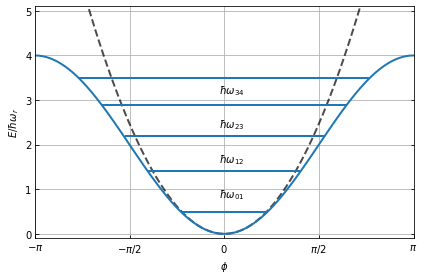

In [22]:
l_siz = 2
plt.plot(x, V_HO,'--', alpha = 0.7, color = 'k', linewidth = l_siz)
plt.plot(x, V_cos, color = 'C0', linewidth = l_siz)
Ec_cos = 1/10
correc = [0,1,3,6,10]

for i in range(5):
    idxs = np.where(V_cos < E_HO+i-correc[i]*Ec_cos)
    plt.plot(x[idxs], E_HO[idxs]+i-correc[i]*Ec_cos, color = 'C0', linewidth = l_siz)
    if i<4:
        letter_label(0.52, 0.19+0.1*i*1.5, '$\hbar\omega_{'+str(i)+str(i+1)+'}$')
    
plt.xlabel('$\phi$')
plt.ylabel('$E/\hbar\omega_r$')
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])
plt.yticks([0,1,2,3,4, 5])
plt.ylim(-0.1, 5.1)
plt.xlim(x.min(), x.max())
plt.tick_params(left=True, right=True)
plt.grid(True)
plt.tight_layout()
plt.show()

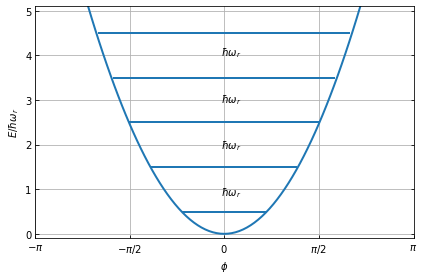

In [23]:
plt.plot(x, V_HO, linewidth = l_siz)
for i in range(5):
    idxs = np.where(V_HO < E_HO+i)
    plt.plot(x[idxs], E_HO[idxs]+i, color = 'C0', linewidth = l_siz)
    if i<4:
        letter_label(0.52, 0.2+i*0.2, '$\hbar\omega_r$')

plt.xlabel('$\phi$')
plt.ylabel('$E/\hbar\omega_r$')
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])
plt.yticks([0,1,2,3,4, 5])
plt.ylim(-0.1, 5.1)
plt.xlim(x.min(), x.max())
plt.tick_params(left=True, right=True)
plt.grid(True)
plt.tight_layout()
plt.show()

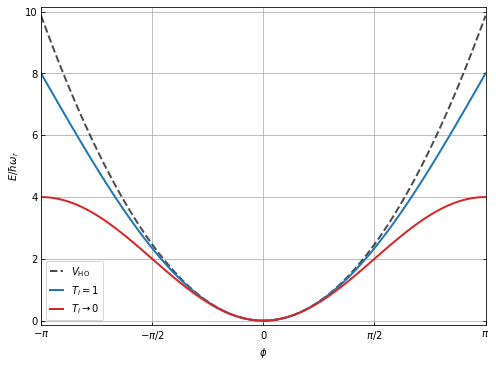

In [36]:
#Andreev potential with cos and harmoninc
plt.figure(figsize=[7,5.2])
plt.plot(x, V_HO,'--', alpha = 0.7, color = 'k', linewidth = l_siz, label = r'$V_{\rm HO}$')
plt.plot(x, V_Andre, color = 'C0', linewidth = l_siz, label = '$T_i=1$')
plt.plot(x, V_cos, color = 'C3', linewidth = l_siz, label = r'$T_i\rightarrow 0$')

Ec_cos = 1/10
correc = [0,1,3,6,10]

    
plt.xlabel('$\phi$')
plt.ylabel('$E/\hbar\omega_r$')
plt.xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi], [r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$'])
plt.yticks([0,2,4,6,8,10])
plt.ylim(-0.15, 10.15)
plt.xlim(x.min(), x.max())
plt.tick_params(left=True, right=True)
plt.grid(True)
plt.legend(handlelength = 1.3)
plt.tight_layout()


# Transmon Energy diagram

In [24]:
ng = np.linspace(-2,2, 401)
Ej = [1, 5, 10, 50, 7.5]
Ec = 1
Es = []
for i in range(5):
    Es.append(energies_vs_ng(Ej[i], Ec, ng, 50, n_deg=0.25))  
    

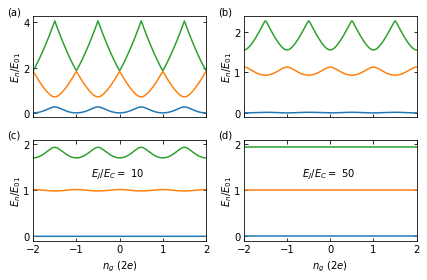

In [26]:
# transmon plot
plt.figure()
a = ['(a)', '(b)', '(c)', '(d)']
for j in range(4):
    plt.subplot2grid((2, 2), (int(np.mod(2,j+1)/2), int(np.mod(j,2))), colspan=1, rowspan=1)
    for i in range(3):
        plt.plot(ng,Es[j][i])
        ax = plt.gca()
        ax.locator_params(nbins=4)
        plt.xticks([-2, -1, 0, 1, 2])
    if j < 2:
        plt.title("$E_J/E_C=$ "+str(int(Ej[j]/Ec)))
        ax.xaxis.set_major_formatter(plt.NullFormatter())
        
    else:
        plt.ylim(-0.1,2.1)
        plt.text(-0.65, 1.3, "$E_J/E_C=$ "+str(int(Ej[j]/Ec)))
        plt.tick_params(left=True, right=True, top = True)
    plt.xlim([-2,2])    
    if j >1:    
        plt.xlabel('$n_g$ ($2e$)')
    plt.ylabel('$E_n/E_{01}$', labelpad = -0)
    plt.tick_params(left=True, right=True)
    letter_label(-0.11, 1.05, a[j])
plt.tight_layout()      
plt.show()  


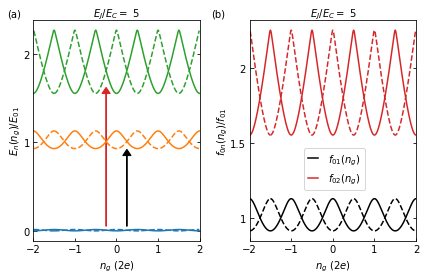

In [27]:
# poisoined figure to illustrate how measurements are performed

fig = plt.figure()
a = ['(a)', '(b)', '(c)', '(d)']
c = ['C0', 'C1', 'C2']

n = 1
num = 2 # number of figs
E = Es[n]
ng1 = ng + 0.5 # make 1e shifted copy to explain measurement of charge dispersion
ng2 = ng - 3.5

# plot energy diagram
plt.subplot2grid((1, num), (0,0), colspan=1, rowspan=1)


# plot the same data on both axes


for i in range(3): # plotting
    plt.plot(ng, E[i], color = c[i])
    plt.plot(ng1[np.where(ng1<2)],E[i][np.where(ng1<2)], '--', color = c[i])
    plt.plot(ng2[np.where(ng2>-2)],E[i][np.where(ng2>-2)], '--', color = c[i])
ax = plt.gca()
ax.locator_params(nbins=4)
ax.arrow(0.25, 0.05, 0., 0.8, head_width=0.2, head_length=0.07, fc='k', ec='k')
ax.arrow(-0.25, 0.05, 0.,1.5, head_width=0.2, head_length=0.07, fc='C3', ec='C3')
plt.xticks([-2, -1, 0, 1, 2])
plt.xlabel('$n_g$ ($2e$)')
plt.ylabel('$E_n(n_g)/E_{01}$', labelpad = -0)
plt.tick_params(left=True, right=True)
letter_label(0.5, 1.03, "$E_J/E_C=$ "+str(int(Ej[n]/Ec)))
letter_label(-0.115, 1.03, '(a)')
plt.xlim([-2,2]) 
# convert to frequencies    
plt.subplot2grid((1, num), (0,1), colspan=1, rowspan=1)    
f = [E[1]-E[0], E[2]-E[0]]

c2 = ['k', 'C3']

for i in range(2):
    plt.plot(ng, f[i], color = c2[i], label = '$f_{0'+str(i+1)+'}(n_g)$')
    plt.plot(ng1[np.where(ng1<2)],f[i][np.where(ng1<2)], '--', color = c2[i])
    plt.plot(ng2[np.where(ng2>-2)],f[i][np.where(ng2>-2)], '--', color = c2[i])

ax = plt.gca()
ax.locator_params(nbins=4)
plt.xticks([-2, -1, 0, 1, 2])
plt.yticks([1, 1.5, 2], [1, 1.5, 2])
plt.xlabel('$n_g$ ($2e$)')
plt.ylabel('$f_{0n}(n_g)/f_{01}$', labelpad = -0)
letter_label(-0.19, 1.03, '(b)')
letter_label(0.5, 1.03, "$E_J/E_C=$ "+str(int(Ej[n]/Ec)))
plt.tick_params(left=True, right=True)
plt.legend(loc = [0.328,0.23], handlelength = 1, handletextpad = 1)
plt.xlim([-2,2]) 

plt.tight_layout()  
plt.show()  

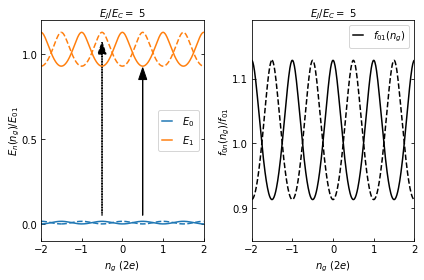

In [28]:
# poisoined figure to illustrate how measurements are performed
fig = plt.figure()
a = ['(a)', '(b)', '(c)', '(d)']
c = ['C0', 'C1', 'C2']

n = 1
num = 2 # number of figs
E = Es[n]
ng1 = ng + 0.5 # make 1e shifted copy to explain measurement of charge dispersion
ng2 = ng - 3.5

# plot energy diagram
plt.subplot2grid((1, num), (0,0), colspan=1, rowspan=1)


# plot the same data on both axes


for i in range(2): # plotting
    plt.plot(ng, E[i], color = c[i], label='$E_'+str(i)+'$')
    plt.plot(ng1[np.where(ng1<2)],E[i][np.where(ng1<2)], '--', color = c[i])
    plt.plot(ng2[np.where(ng2>-2)],E[i][np.where(ng2>-2)], '--', color = c[i])
ax = plt.gca()
ax.locator_params(nbins=4)
ax.arrow(0.5, 0.05, 0., 0.8, head_width=0.2, head_length=0.07, fc='k', ec='k')
ax.arrow(-0.5, 0.05, 0.,0.95, head_width=0.2, head_length=0.07, fc='k', ec='k', linestyle='dashed')
plt.xticks([-2, -1, 0, 1, 2])
plt.xlabel('$n_g$ ($2e$)')
plt.ylabel('$E_n(n_g)/E_{01}$', labelpad = -0)
plt.tick_params(left=True, right=True)
letter_label(0.5, 1.03, "$E_J/E_C=$ "+str(int(Ej[n]/Ec)))
plt.xlim([-2,2]) 
plt.ylim([-0.1, 1.2])
plt.legend(handlelength = 1, handletextpad = 1)
# convert to frequencies    
plt.subplot2grid((1, num), (0,1), colspan=1, rowspan=1)    
f = [E[1]-E[0], E[2]-E[0]]

c2 = ['k', 'C3']

for i in range(1):
    plt.plot(ng, f[i], color = c2[i], label = '$f_{0'+str(i+1)+'}(n_g)$')
    plt.plot(ng1[np.where(ng1<2)],f[i][np.where(ng1<2)], '--', color = c2[i])
    plt.plot(ng2[np.where(ng2>-2)],f[i][np.where(ng2>-2)], '--', color = c2[i])

ax = plt.gca()
ax.locator_params(nbins=4)
plt.xticks([-2, -1, 0, 1, 2])
plt.xlabel('$n_g$ ($2e$)')
plt.ylabel('$f_{0n}(n_g)/f_{01}$', labelpad = -0)
letter_label(0.5, 1.03, "$E_J/E_C=$ "+str(int(Ej[n]/Ec)))
plt.tick_params(left=True, right=True)
plt.legend( handlelength = 1, handletextpad = 1)
plt.xlim([-2,2]) 
plt.ylim([0.85, 1.19])
plt.tight_layout()  
plt.show()  

# comparison figs - same Ej/Ec - diffenrent T

In [29]:
ng = np.linspace(-4,4, 401)
E_model = []
E_transmon = []
ratio = [5, 10]
Tss = np.array([0.5, 0.9, 1])
Delta = 45
for j in range(2):
    en_trans = []
    Ecs = Delta*Tss/(4*ratio[j]) # balance Ec so Ej/Ec = 5, use Ej=Delta/4*T
    for i in range(3):
        en = []
        if i != 2:
            en = get_energies_1band(Ecs[i], Delta, Tss[i], ng)
        else:
            en = get_energies_1band(Ecs[i], Delta, Tss[i], ng, N=101)    
        en_trans.append(en) 
    en_trans = np.array(en_trans)   
    en_koch = energies_vs_ng(ratio[j], 1, 0.5*ng, 50, n_deg=0.25)
    E_model.append(en_trans)
    E_transmon.append(en_koch)

6.110107531865474 45 1.125
11.934748705494219 45 2.025
13.623933260965643 45 2.25
4.571273071985708 45 0.5625
8.617470273441317 45 1.0125
9.752793111787248 45 1.125


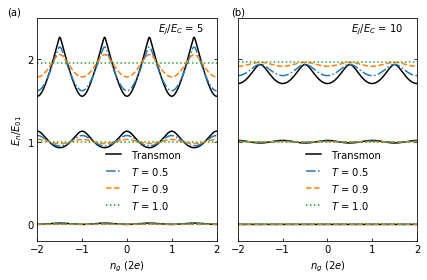

In [30]:
# formatting stuff:
colors = ['k', 'C0', 'C1', 'C2']
c = ['C0', 'C1', 'C2'] # color fig b-d
m = ['o', 'o', 'o']
lpad = 1. # distance between legend and text
colspace = 0.5 # 
lext = 1.5 # how wide legends are
t_cor = [0.15, 1.4]
fsiz = 14.
label_koch ='Transmon'
l = ['-.', '--', ':']
plt.figure()
for k in range(2):
    plt.subplot2grid((1, 2), (0, k), colspan=1, rowspan=1)
    plt.yticks([0, 1, 2])
    if k == 0:
        letter_label(-0.13, 1.03, '(a)')
        
    else:
        letter_label(-0.0, 1.03, '(b)')
    plt.tick_params(left=True, right=True)
    plt.xlabel('$n_g$ ($2e$)')
    letter_label(0.8-0.02*k, 0.95, '$E_J/E_C$ = '+str(ratio[k]))
    for i in range(3):
        if i == 0:
            plt.plot(0.5*ng, E_transmon[k][:][i], color = 'k', label = label_koch)#+str(ratio(5)+ ',Transmon')   
        else:
            plt.plot(0.5*ng, E_transmon[k][:][i], color = 'k')   
    for i in range(3):
        labl = '$T$ = '+str(np.round(Tss[i],4))
        for j in range(3):
            if j == 0:
                plt.plot(ng*0.5, E_model[k][i,j], l[i], color = c[i], label = labl)#, linewidth = lsiz)
            else:
                plt.plot(ng*0.5, E_model[k][i,j], l[i], color = c[i])#, linewidth = lsiz)

    plt.ylim(-0.2, 2.5)
   
    if k == 0:
        plt.ylabel('$E_n/E_{01}$')
        
    else:
        ax = plt.gca()
        ax.yaxis.set_major_formatter(plt.NullFormatter())
        #plt.legend(frameon = True, loc = [0.5,0.1], handlelength = lext, ncol=1, handletextpad = lpad, columnspacing=1.5)     
    plt.legend(frameon = False, loc='upper right', bbox_to_anchor=(0.85, 0.45), handlelength = lext, ncol=1, handletextpad = lpad, columnspacing=1.5)             

    plt.xlim([-2,2])

plt.tight_layout()

plt.show()

# Plots vs transmission

In [31]:
ratio = 10
Ts = np.linspace(0.01,1, 51)
Ts1 = np.array([0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.925])
Ts2 = np.linspace(0.95,0.99, 21)
Ts3 = np.linspace(0.99,1, 201)
Ts = np.concatenate((Ts1,Ts2, Ts3))
Delta = 10
alpha_vs_t = np.zeros(len(Ts))
alpha_transmon = np.zeros(len(Ts))
disp_vs_t = np.zeros(len(Ts))
for i,t in enumerate(Ts):
    en_trans = []
    Ecs = Delta*t/(4*ratio)
    alpha_vs_t[i] = get_anharmonicity(Ecs, Delta, t)/Ecs
    alpha_transmon[i] = find_anharmonicity(Ecs, Ecs*ratio)/Ecs
    disp_vs_t[i] = get_disp(Ecs, Delta, t)/get_freq(Ecs, Delta, t) 

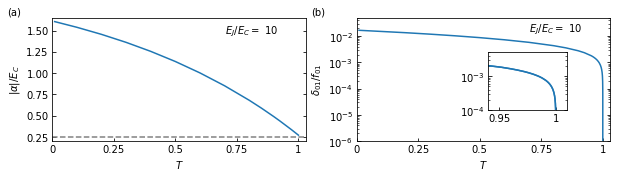

In [32]:
plt.figure(figsize=[10, 5])
plt.subplot2grid((2, 2), (1, 0), colspan=1, rowspan=1)
xlim = [-0.0, 1.03]
plt.xlim(xlim)
plt.plot(xlim, [0.25, 0.25], '--', color = 'grey' )
plt.plot(Ts, -alpha_vs_t)
#plt.plot(Ts, -alpha_transmon)
plt.xlabel('$T$')
plt.ylabel('$|\\alpha|$/$E_C$')
plt.ylim(0.2, 1.65)
plt.xticks([0, 0.25, 0.5, 0.75, 1])
ax=plt.gca()
ax.set_xticklabels([0, 0.25, 0.5, 0.75, 1])
plt.tick_params(left=True, right=True)
plt.text(0.7, 1.46, "$E_J/E_C=$ "+str(int(ratio)))

#a = np.array[-1,2]
letter_label(-0.15, 1.05, '(a)')
#dispersion fig

plt.subplot2grid((2, 2), (1, 1), colspan=1, rowspan=1)
plt.plot(Ts, disp_vs_t, '-')
plt.xlabel('$T$')
plt.ylabel('$\delta_{01}$/$f_{01}$')
plt.yscale('log')
plt.xlim(xlim)
plt.ylim(1e-6, 0.05)
plt.tick_params(bottom=True, top=False, right = True, which = 'both')
plt.xticks([0, 0.25, 0.5, 0.75, 1])
ax=plt.gca()
ax.set_xticklabels([0, 0.25, 0.5, 0.75, 1])
letter_label(-0.15, 1.05, '(b)')  
plt.text(0.7, 0.015, "$E_J/E_C=$ "+str(int(ratio)))
# inset zoom at large transmission

inset_axes(plt.gca(), width=1.1, height=0.8, bbox_to_anchor=(.55, 2.1e-1, .3, .55),
                   bbox_transform=ax.transAxes)
for i in range(2):
    plt.plot(Ts, disp_vs_t, '-', color = 'C0')
    #plt.xscale('log')
    plt.yscale('log')
    plt.xlim(0.94,1.01)
    plt.ylim(1e-4, 0.005)
    plt.xticks([0.95, 1])

    ax1 = plt.gca()
    ax1.set_xticklabels([0.95, 1])
    
    plt.tick_params(bottom=True, top=False, right = True, which = 'both')
    
plt.show()

# Short junction energies

In [33]:
Ts1 = np.array([0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.85, 0.9, 0.925])
Ts2 = np.linspace(0.95,0.99, 21)
Ts3 = np.linspace(0.99,1, 21)
Ts = np.concatenate((Ts1,Ts2, Ts3))

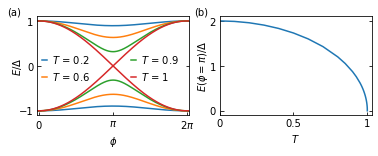

In [34]:
plt.subplot2grid((2, 2), (1, 0), colspan=1, rowspan=1)
plot_andreev_spectrum_short_junction(1, 0.2)
plot_andreev_spectrum_short_junction(1, 0.6)
plot_andreev_spectrum_short_junction(1, 0.9)
plot_andreev_spectrum_short_junction(1, 1)
plt.legend(loc = [.01, 0.295],frameon = False, handlelength = 0.5, handletextpad = 0.5, ncol = 2, columnspacing=4)
plt.yticks([-1,0,1])
letter_label(-0.15, 1.05, '(a)')

#plt.show()
plt.subplot2grid((2, 2), (1, 1), colspan=1, rowspan=1)
plt.xlim([0,1.03])
plot_gap_at_pi(1, Ts)
ax1 = plt.gca()
plt.xticks([0, 0.5, 1])
ax1.set_xticklabels([0, 0.5, 1])
letter_label(-0.12, 1.05, '(b)')
plt.show()